In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load a neural hash seed

You will need 4 files from a recent macOS or iOS build:

- neuralhash_128x96_seed1.dat
- NeuralHashv3b-current.espresso.net
- NeuralHashv3b-current.espresso.shape
- NeuralHashv3b-current.espresso.weights

https://github.com/AsuharietYgvar/AppleNeuralHash2ONNX

In [2]:
seed1_path = 'models/neuralhash_128x96_seed1.dat'

seed1 = open(seed1_path, 'rb').read()[128:]
seed1 = np.frombuffer(seed1, dtype=np.float32)
seed1 = seed1.reshape([96, 128])

## Load a neural hash model

Convert onnx weights to TensorFlow model

https://github.com/onnx/onnx-tensorflow

In [3]:
model = tf.saved_model.load('models/output')

## Load a sample image

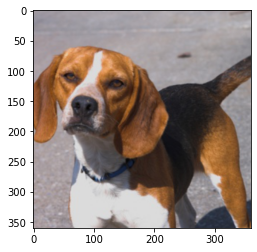

(1, 3, 360, 360)


In [4]:
image = Image.open('images/dog.png').convert('RGB')
image = image.resize([360, 360])

plt.imshow(image)
plt.show()

input_image = np.array(image).astype(np.float32) / 255.0
input_image = input_image * 2.0 - 1.0
input_image = input_image.transpose(2, 0, 1).reshape([1, 3, 360, 360])

print(input_image.shape)

## Inference

Get logits of an input image from neural hash model

In [5]:
output = model(image=input_image)

output['leaf/logits'].numpy().flatten()

array([ 7.27319489e+01, -1.19335060e+01,  4.59686279e+01, -1.63756046e+01,
       -9.98744125e+01, -4.18211784e+01,  1.40822144e+01,  4.33237915e+01,
        1.74896069e+01,  4.20998535e+01,  5.93912840e+00, -5.33996849e+01,
       -2.47213631e+01,  2.42439899e+01, -6.58418579e+01,  5.40843124e+01,
        2.02421131e+01,  1.96410675e+01,  3.64377861e+01, -1.73105183e+01,
       -4.75332108e+01,  2.93492832e+01,  5.98620749e+00,  6.01031876e+01,
        1.17661125e+02,  1.01173859e+01,  4.06535263e+01, -3.90310364e+01,
        3.42507019e+01, -1.13642761e+02,  5.01909523e+01, -4.18824539e+01,
       -9.63772202e+00,  3.19029856e+00,  1.00907860e+02, -3.10769057e+00,
        1.01301641e+01, -2.86706676e+01, -4.48114014e+01, -1.32252197e+02,
        7.31574783e+01, -7.91928247e-02,  5.99069366e+01, -6.36584625e+01,
        6.22398415e+01,  5.24968071e+01, -3.20476608e+01, -2.28955708e+01,
       -4.60929394e+00,  1.58357525e+01,  1.19200737e+02, -4.50719872e+01,
       -1.05075283e+01,  

## Logit hashing

In [6]:
hash_output = seed1.dot(output['leaf/logits'].numpy().flatten())
hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)

hash_hex

'59a34eabe31910abfb06f308'

## Functionalize

In [7]:
def preprocess(image):
    image = image.resize([360, 360])
    input_image = np.array(image).astype(np.float32) / 255.0
    input_image = input_image * 2.0 - 1.0
    input_image = input_image.transpose(2, 0, 1).reshape([1, 3, 360, 360])
    return input_image

def inference(input_image):
    output = model(image=input_image)
    return output['leaf/logits']

def get_hash(output):
    hash_output = seed1.dot(output.numpy().flatten())
    hash_bits = ''.join(['1' if it >= 0 else '0' for it in hash_output])
    hash_hex = '{:0{}x}'.format(int(hash_bits, 2), len(hash_bits) // 4)
    return hash_hex

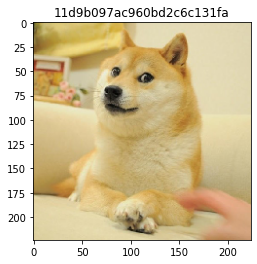

In [8]:
dog = Image.open('images/dog2.png')
dog_hash = get_hash(inference(preprocess(dog)))

plt.title(dog_hash)
plt.imshow(dog)

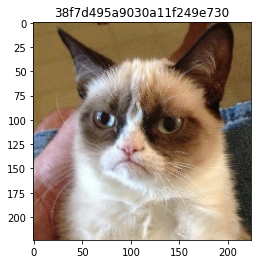

In [9]:
cat = Image.open('images/cat2.png')
cat_hash = get_hash(inference(preprocess(cat)))

plt.title(cat_hash)
plt.imshow(cat)

## Adversarial attack

#508	Loss=946, Target: 11d9b097ac960bd2c6c131fa, Adv: 11d9b097ac960bd2c6c131faae
Collision Found! 508


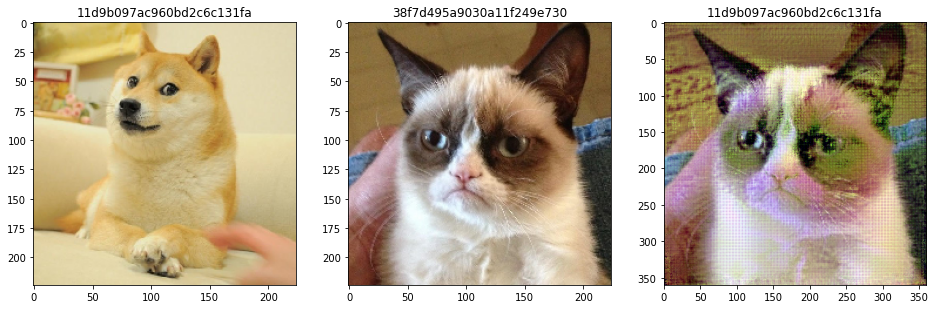

In [10]:
os.makedirs('samples', exist_ok=True)

i = 0
lr = 1e-03

cat_input = preprocess(cat)
dog_logits = inference(preprocess(dog))
adv_input = cat_input.copy()

while True:
    adv_tensor = tf.convert_to_tensor(adv_input, dtype=tf.float32)

    with tf.GradientTape() as t:
        t.watch(adv_tensor)
        adv_logits = model(image=adv_tensor)['leaf/logits']
        loss = tf.nn.l2_loss(adv_logits - dog_logits)

    grad = t.gradient(loss, adv_tensor).numpy()
    adv_input -= lr * grad

    adv_input = np.clip(adv_input, -1, 1)
    
    adv_hash = get_hash(inference(adv_input))

    print(f'#{i}\tLoss={int(loss)}, Target: {dog_hash}, Adv: {adv_hash}', end='\r')

    if i % 100 == 0 or dog_hash == adv_hash:
        adv_img = ((adv_input[0] + 1.) / 2. * 255.).transpose(1, 2, 0).astype(np.uint8)
        Image.fromarray(adv_img).save(f'samples/{i}.png', quality=100)
        
        if dog_hash == adv_hash:
            print('\n====================')
            print(f'Collision Found! {i}')
            
            fig, axes = plt.subplots(1, 3, figsize=(16, 10))
            axes[0].set_title(dog_hash)
            axes[0].imshow(dog)
            axes[1].set_title(cat_hash)
            axes[1].imshow(cat)
            axes[2].set_title(adv_hash)
            axes[2].imshow(adv_img)
            break
    i += 1

## OH MY GIRL

### Yooa

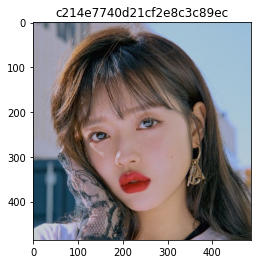

In [14]:
target_img = Image.open('images/yooa.jpg')
target_hash = get_hash(inference(preprocess(target_img)))

plt.title(target_hash)
plt.imshow(target_img)

### Hyojung

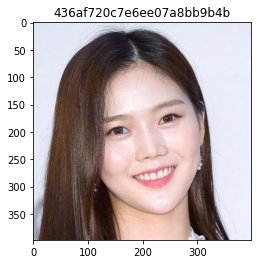

In [15]:
input_img = Image.open('images/hyojung.jpg')
input_hash = get_hash(inference(preprocess(input_img)))

plt.title(input_hash)
plt.imshow(input_img)

#983	Loss=286, Target: c214e7740d21cf2e8c3c89ec, Adv: c214e7740d21cf2e8c3c89ecea
Collision Found! 983


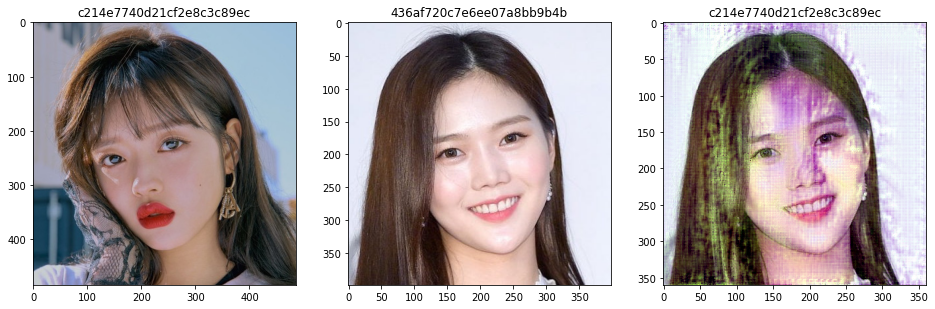

In [18]:
i = 0
lr = 1e-03

target_logits = inference(preprocess(target))
adv_input = preprocess(input_img).copy()

while True:
    adv_tensor = tf.convert_to_tensor(adv_input, dtype=tf.float32)

    with tf.GradientTape() as t:
        t.watch(adv_tensor)
        adv_logits = model(image=adv_tensor)['leaf/logits']
        loss = tf.nn.l2_loss(adv_logits - target_logits)

    grad = t.gradient(loss, adv_tensor).numpy()
    adv_input -= lr * grad

    adv_input = np.clip(adv_input, -1, 1)
    
    adv_hash = get_hash(inference(adv_input))

    print(f'#{i}\tLoss={int(loss)}, Target: {target_hash}, Adv: {adv_hash}', end='\r')

    if i % 100 == 0 or target_hash == adv_hash:
        adv_img = ((adv_input[0] + 1.) / 2. * 255.).transpose(1, 2, 0).astype(np.uint8)
        Image.fromarray(adv_img).save(f'samples/{i}.png', quality=100)
        
        if target_hash == adv_hash:
            print('\n====================')
            print(f'Collision Found! {i}')
            
            fig, axes = plt.subplots(1, 3, figsize=(16, 10))
            axes[0].set_title(target_hash)
            axes[0].imshow(target_img)
            axes[1].set_title(input_hash)
            axes[1].imshow(input_img)
            axes[2].set_title(adv_hash)
            axes[2].imshow(adv_img)
            break
    i += 1